#Trabajo final de LLM

#Clasificador de sentimientos de productos de [amazon](https://huggingface.co/datasets/amazon_polarity)


###**Alumno: Christian Canaan Castro Botek**

***Especialización en Inteligencia Artificial***

***FIUBA***

**Introducción:** En el presente trabajo utilizaremos un modelo de lenguaje grande (LLM) para resolver un problema de clasificación de sentimientos en reseñas de productos de amazon.



Los datos abarcan un período de 18 años, incluidas ~35 millones de reseñas hasta marzo de 2013. Las reseñas incluyen información sobre productos y usuarios, calificaciones y una reseña en texto sin formato.

*'title': una cadena que contiene el título de la reseña, con comillas dobles ("") y cualquier comilla doble interna con 2 comillas dobles (""). Las nuevas líneas tienen como escape una barra invertida seguida de un carácter "n". , es decir "\n".
'content': una cadena que contiene el cuerpo del documento, con comillas dobles ("") y cualquier comilla doble interna con 2 comillas dobles (""). Las nuevas líneas tienen como escape una barra invertida seguida de un carácter "n". , es decir "\n".
'label': calificación 1 (positiva) o 0 (negativa).*

Para el entrenamiento no usaremos todo el dataset, solo una porción reducida del mismo para mantenernos al margen de los tiempo de ejecución que ofrece el Colab versión free con GPU incluida.

# 1. Instalación de bibliotecas

Hacemos uso de 3 bibliotecas:

**datasets:** Dada por HuggingFace para cargar directamente el dataset y proporciona algunas herramientas de manipulación y preprocesamiento de datos.

**transformers:** Dada por HuggingFace para la implementación de modelos de NPL preentrenados, como el modelo BERT que usaremos en este proyecto.

**scikit-learn:** Proporciona una variedad de herramientas para tareas de clasificación, regresión, clustering, preprocesamiento de datos, y evaluación de modelos. En este proyecto solo la usamos para definir una función de calculo de métricas.



In [25]:
# Instalación de bibliotecas
!pip install -U transformers datasets evaluate accelerate
!pip install tensorboard tensorboardX
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets
!pip install torch
!pip install scikit-learn

# 2. Imports y detección de GPU

Verificaremos si dentro del entorno disponemos de un GPU para utilizarla.

In [26]:
# Imports
from datasets import load_dataset
import random
import os
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from collections import Counter

In [27]:
# Detección de GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU: Tesla T4


# 3. Preprocesamiento

Usaremos el modelo preentrenado de BERT, tenemos que tomar el texto crudo presente en el dataset y darle un formato que el modelo BERT pueda entender. Este preprocesado consiste en convertir las frases en números (tokens) y asegurarse que las secuencias de entrada tengan la misma longitud.






## 3.1. Carga del dataset

In [28]:
# Definimos un "sample_size" para no trabajar con todo el dataset
sample_size = 10000

# Carga del dataset desde Hugging face
dataset = load_dataset('amazon_polarity')

In [29]:
# Tomamos una porción del dataset según sample_size especificado para train y test
train_sample = dataset['train'].shuffle(seed=42).select(range(sample_size))
test_sample = dataset['test'].shuffle(seed=42).select(range(sample_size))

In [30]:
# Algunas muestras del dataset de entrenamiento
print("dataset de entrenamiento:")
for i in range(5):
    print(train_sample[i])

dataset de entrenamiento:
{'label': 0, 'title': 'Anyone who likes this better than the Pekinpah is a moron.', 'content': "All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act like hard cases. Action wise, the robbery scene in the Pekinpah version was about 100 times more exciting and suspenseful than anything in this re-make."}
{'label': 0, 'title': 'Author seems mentally unstable', 'content': 'I know that Tom Robbins has a loyal following and I started the book with high expectations. However, I did not enjoy this book as it was too much work to follow his confused logic. I think that he was under the influence during most of time that he wrote.'}

Inspeccionamos el dataset viendo para todo el conjunto como estan distribuidos los labels

In [31]:
label_counts_train = Counter(dataset['train']['label'])
label_counts_test = Counter(dataset['test']['label'])

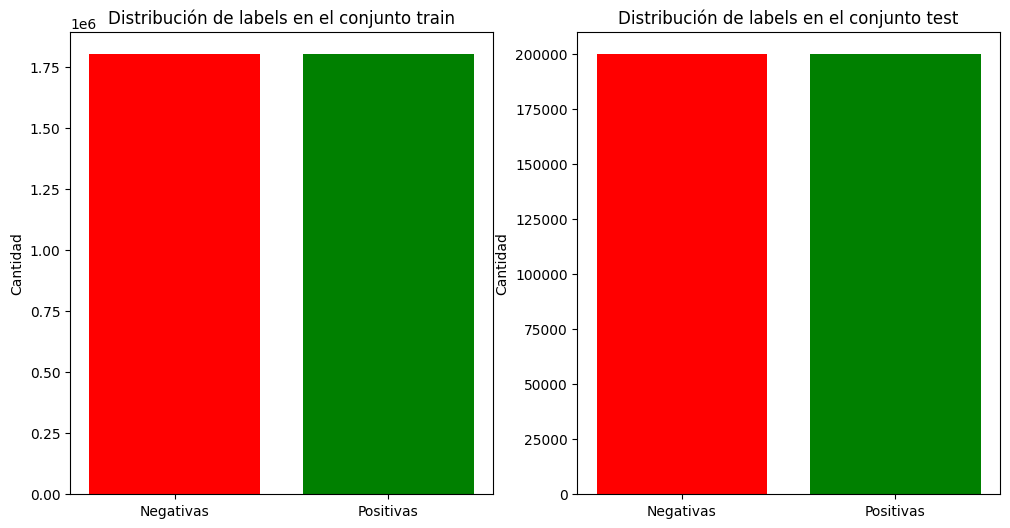

In [32]:
labels = ['Negativas', 'Positivas']
train_counts = [label_counts_train[0], label_counts_train[1]]
test_counts = [label_counts_test[0], label_counts_test[1]]

x = range(len(labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para el conjunto de entrenamiento
ax[0].bar(x, train_counts, color=['red', 'green'])
ax[0].set_title('Distribución de labels en el conjunto train')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Cantidad')

# Gráfico para el conjunto de prueba
ax[1].bar(x, test_counts, color=['red', 'green'])
ax[1].set_title('Distribución de labels en el conjunto test')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Cantidad')

plt.show()

## 3.2 Definición del tokenizer preentrenado y del modelo

Para el modelo usamos 2 etiquetas porque vamos a realizar una clasificación binaria (Positiva o negativa) para las reseñas.

In [33]:
# Tokenizer preentrenado (BERT).
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Definición del modelo (2 etiquetas).
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Aseguramos uso de GPU si está disponible.
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3.3 Preprocesamiento

Hacemos la tokenización. Si tenemos por ejemplo:

"This is a great product. I highly recommend it!"

luego del tokenizado tenemos:

[101, 2023, 2003, 1037, 2307, 4031, 1012, 1045, 3811, 16770, 2009, 999, 102]

donde cada palabra fue convertida en un número que posteriormente el modelo sabrá interpretar.

En caso de que la sentencia sea mas corta que max_length, se completan con 0

In [34]:
# Función de preprocesamiento
def preprocess_function(examples):
    return tokenizer(examples['content'], max_length=128, padding="max_length", truncation=True)

# Aplicar la función de preprocesamiento a cada ejemplo en dataset_sample por lotes (batched)
encoded_dataset = train_sample.map(preprocess_function, batched=True)

In [35]:
print("Ejemplo de encoded:")
print(encoded_dataset[1])

Ejemplo de encoded:
{'label': 0, 'title': 'Author seems mentally unstable', 'content': 'I know that Tom Robbins has a loyal following and I started the book with high expectations. However, I did not enjoy this book as it was too much work to follow his confused logic. I think that he was under the influence during most of time that he wrote.', 'input_ids': [101, 1045, 2113, 2008, 3419, 18091, 2038, 1037, 8884, 2206, 1998, 1045, 2318, 1996, 2338, 2007, 2152, 10908, 1012, 2174, 1010, 1045, 2106, 2025, 5959, 2023, 2338, 2004, 2009, 2001, 2205, 2172, 2147, 2000, 3582, 2010, 5457, 7961, 1012, 1045, 2228, 2008, 2002, 2001, 2104, 1996, 3747, 2076, 2087, 1997, 2051, 2008, 2002, 2626, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 3.4 Conversión del preprocesado en tensores

BERT (Implementado con PyTorch) opera con tensores que son estructuras de datos como las matrices pero con multiples dimensiones. En definitiva, preparamos los datos de entrada en un formato que el modelo BERT puede procesar directamente

type='torch': Especifica que queremos convertir los datos a tensores de PyTorch.

columns=['input_ids', 'attention_mask', 'label']: Especifica qué columnas del dataset deben ser convertidas a tensores.




In [36]:
# Definir la función de conversión a tensores
def convert_to_tensors(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

# Convertir el dataset a tensores
encoded_dataset = convert_to_tensors(encoded_dataset)

In [37]:
print("Ejemplo de tensor:")
print(encoded_dataset[1])

Ejemplo de tensor:
{'label': tensor(0), 'input_ids': tensor([  101,  1045,  2113,  2008,  3419, 18091,  2038,  1037,  8884,  2206,
         1998,  1045,  2318,  1996,  2338,  2007,  2152, 10908,  1012,  2174,
         1010,  1045,  2106,  2025,  5959,  2023,  2338,  2004,  2009,  2001,
         2205,  2172,  2147,  2000,  3582,  2010,  5457,  7961,  1012,  1045,
         2228,  2008,  2002,  2001,  2104,  1996,  3747,  2076,  2087,  1997,
         2051,  2008,  2002,  2626,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

## 3.5 División en train y test

In [38]:
# Dividir el dataset en entrenamiento y evaluación
train_size = int(0.8 * len(encoded_dataset))
train_dataset, eval_dataset = torch.utils.data.random_split(encoded_dataset, [train_size, len(encoded_dataset) - train_size])


# 4. Trainer y entrenamiento



In [39]:
# Subclase para registrar el training_ accuracy, por: https://discuss.huggingface.co/t/metrics-for-training-set-in-trainer/2461
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Subclassed to compute training accuracy.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)

        # Calculate and log training accuracy
        if "labels" in inputs:
            preds = outputs.logits.detach()
            acc = (
                (preds.argmax(axis=1) == inputs["labels"])
                .type(torch.float)
                .mean()
                .item()
            )
            self.log({"training_accuracy": acc})

        # Save past state if it exists
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

In [40]:
# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Número de épocas de entrenamiento
    per_device_train_batch_size=16,   # Tamaño del batch de entrenamiento (8/16/32)
    per_device_eval_batch_size=16,    # Tamaño del batch de evaluación (8/16/32)
    warmup_steps=500,                # Pasos de calentamiento, ayuda a estabilizar el entrenamiento al inicio, evitando cambios bruscos en los pesos del modelo
    weight_decay=0.01,               # Factor de decaimiento del peso, reduce el sobreajuste en el conjunto de entrenamiento
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",     # Estrategia de evaluación: evalúa al final de cada época
)

# Función de cálculo de métricas
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# # Crear el Trainer
# trainer = Trainer(
#     model=model,                         # El modelo a entrenar
#     args=training_args,                  # Argumentos de entrenamiento
#     train_dataset=encoded_dataset,       # Datos de entrenamiento
#     eval_dataset=eval_dataset,           # Datos de evaluación
#     compute_metrics=compute_metrics      # Función de cálculo de métricas
# )
#
# # Entrenar el modelo
# trainer.train()

# Crear el CustomTrainer
custom_trainer = CustomTrainer(
    model=model,                         # El modelo a entrenar
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=encoded_dataset,       # Datos de entrenamiento
    eval_dataset=eval_dataset,           # Datos de evaluación
    compute_metrics=compute_metrics      # Función de cálculo de métricas
)

# Entrenar el modelo
custom_trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.327800,0.138676,0.957500,0.957648,0.966801,0.948667
2,0.108000,0.049754,0.985500,0.985636,0.989066,0.982231
3,0.092500,0.018071,0.996500,0.996547,0.996055,0.997038


TrainOutput(global_step=1875, training_loss=0.1993116703857978, metrics={'train_runtime': 722.6271, 'train_samples_per_second': 41.515, 'train_steps_per_second': 2.595, 'total_flos': 1973332915200000.0, 'train_loss': 0.1993116703857978, 'epoch': 3.0})

In [41]:
# Visualización de todos los parametros
training_args_dict = training_args.to_dict()
for key, value in training_args_dict.items():
    print(f"{key}: {value}")

output_dir: ./results
overwrite_output_dir: False
do_train: False
do_eval: True
do_predict: False
eval_strategy: epoch
prediction_loss_only: False
per_device_train_batch_size: 16
per_device_eval_batch_size: 16
per_gpu_train_batch_size: None
per_gpu_eval_batch_size: None
gradient_accumulation_steps: 1
eval_accumulation_steps: None
eval_delay: 0
learning_rate: 5e-05
weight_decay: 0.01
adam_beta1: 0.9
adam_beta2: 0.999
adam_epsilon: 1e-08
max_grad_norm: 1.0
num_train_epochs: 3
max_steps: -1
lr_scheduler_type: linear
lr_scheduler_kwargs: {}
warmup_ratio: 0.0
warmup_steps: 500
log_level: passive
log_level_replica: warning
log_on_each_node: True
logging_dir: ./logs
logging_strategy: steps
logging_first_step: False
logging_steps: 10
logging_nan_inf_filter: True
save_strategy: steps
save_steps: 500
save_total_limit: None
save_safetensors: True
save_on_each_node: False
save_only_model: False
restore_callback_states_from_checkpoint: False
no_cuda: False
use_cpu: False
use_mps_device: False
seed:

# 5. Evaluación del modelo

In [42]:
# Evaluar el modelo
# eval_results = trainer.evaluate()

# Evaluar el modelo
eval_results = custom_trainer.evaluate()

print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.01807056926190853, 'eval_accuracy': 0.9965, 'eval_f1': 0.9965466206216083, 'eval_precision': 0.9960552268244576, 'eval_recall': 0.9970384995064165, 'eval_runtime': 13.6846, 'eval_samples_per_second': 146.149, 'eval_steps_per_second': 9.134, 'epoch': 3.0}


In [43]:
# Guadado del modelo (Requiere conexión y permisos al drive)
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# 6. Visualización de los resultados

In [46]:
# Para poder graficar y observar el Train Loss y Train accuracy tenemos que inspeccionar como estan guaradados en los logs y extraer los valores
from tensorboard.backend.event_processing import event_accumulator

def identify_log_keys(log_dir='./logs'):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Obtener las claves disponibles en los logs
    scalar_keys = ea.Tags()['scalars']
    return scalar_keys

# Identificar las claves disponibles en los logs
scalar_keys = identify_log_keys('./logs')
print(f"Available scalar keys: {scalar_keys}")

Available scalar keys: ['train/training_accuracy', 'train/epoch', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'eval/loss', 'eval/accuracy', 'eval/f1', 'eval/precision', 'eval/recall', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


Length of epochs: 187
Length of train_loss: 187
Length of train_accuracy: 187


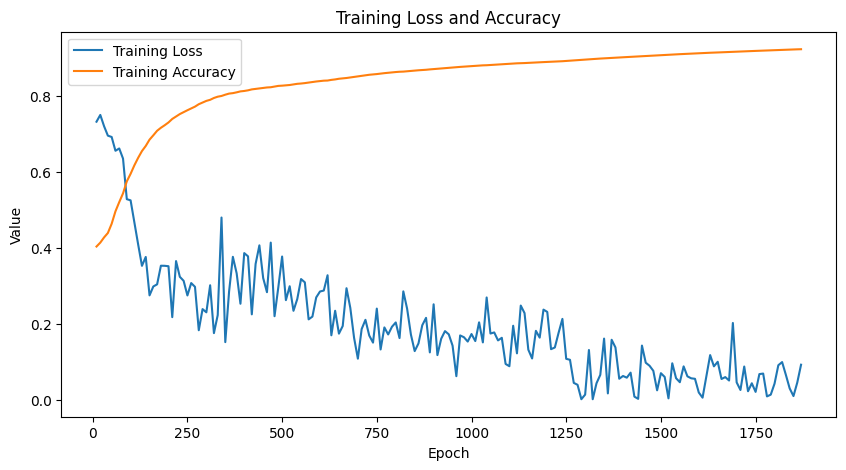

In [47]:
# Función que accede al registro de logs y extrae los valores
def load_logs(log_dir='./logs', loss_key='train/loss', accuracy_key='train/training_accuracy'):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Extraer los resúmenes de escalares para loss y accuracy
    train_loss = ea.Scalars(loss_key)
    train_accuracy = ea.Scalars(accuracy_key)

    # SE crean diccionarios para alinear los datos por paso (step)
    loss_dict = {entry.step: entry.value for entry in train_loss}
    accuracy_dict = {entry.step: entry.value for entry in train_accuracy}

    # Identificar los pasos comunes
    common_steps = sorted(set(loss_dict.keys()).intersection(accuracy_dict.keys()))

    epochs = common_steps
    train_loss_values = [loss_dict[step] for step in common_steps]

    # Para train_accuracy, calculamos el promedio por epoch
    accuracy_steps = sorted(accuracy_dict.keys())
    epoch_accuracy = []
    for step in common_steps:
        # Encontrar los valores de precisión correspondientes a este paso
        accuracy_values = [accuracy_dict[s] for s in accuracy_steps if s <= step]
        if accuracy_values:
            epoch_accuracy.append(np.mean(accuracy_values))
        else:
            epoch_accuracy.append(0)  # Valor por defecto si no hay datos

    return epochs, train_loss_values, epoch_accuracy

# Cargar los datos de los logs
epochs, train_loss, train_accuracy = load_logs('./logs')

# Verificar las longitudes nuevamente para cerciorarnos que son iguales y eliminamos el problema de dimensiones
print(f"Length of epochs: {len(epochs)}")
print(f"Length of train_loss: {len(train_loss)}")
print(f"Length of train_accuracy: {len(train_accuracy)}")

# Graficar las curvas de pérdida y precisión de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

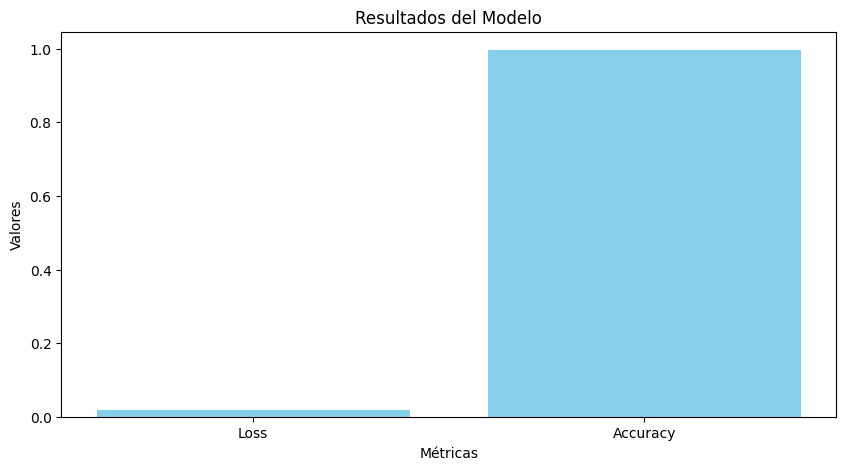

In [48]:
import matplotlib.pyplot as plt

# Datos para el gráfico
labels = ['Loss', 'Accuracy']
values = [eval_results['eval_loss'], eval_results['eval_accuracy']]

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados del Modelo')
plt.show()

# 7. Verificación del modelo

Generamos nuevas reviews para probar si el modelo es capaz de clasificar correctamente los sentimientos.

## 7.1 Nuevas reseñas

In [49]:
# Nuevas reseñas para probar el modelo
new_reviews = [
    "This product is amazing! I love it and will definitely buy again.",
    "Terrible experience. The product broke after one use.",
    "Not bad, but could be better. The quality is okay.",
    "Excellent quality and fast shipping. Highly recommend this!",
    "Waste of money. I'm very disappointed.",
    "Absolutely fantastic! Exceeded my expectations in every way.",
    "Horrible service, and the product arrived damaged.",
    "Pretty decent for the price. Satisfied with the purchase.",
    "I am thrilled with this product! It's exactly what I needed.",
    "The worst purchase I've ever made. Completely useless.",
    "Superb quality and very durable. Will buy more in the future.",
    "Not worth the money. Very low quality and unreliable.",
    "Great value for money. Performs well and looks good.",
    "Very unhappy with this product. It stopped working after a week.",
    "Love it! The design is sleek and it works perfectly.",
    "Terrible. It didn't work as advertised and customer service was unhelpful."
]

## 7.2 Tokenizado de las nuevas reseñas

In [50]:
# Tokenizar las nuevas reseñas
tokenized_new_reviews = tokenizer(new_reviews, padding="max_length", truncation=True, return_tensors="pt").to(device)

## 7.3 Realización y obtención de predicciones

In [51]:
# Hacer predicciones
model.eval()  # Colocamos el modelo en modo de evaluación
with torch.no_grad(): # Ya que no se necesita calcular gradientes durante la inferencia.
    outputs = model(**tokenized_new_reviews)

# Obtener las predicciones
predictions = torch.argmax(outputs.logits, dim=-1) # Las salidas del modelo son logits, que son las puntuaciones antes de aplicar una función de activación como softmax

## 7.4 Mapeo de predicciónes y muestra de resultados

Los logits son valores continuos que representan la confianza del modelo en cada clase. Para nuestro caso, habran dos logits por reseña y como tenemos dos etiquetas, se referencia a una clase predicha (Reseña positiva o negativa) por lo que  definimos estos labels y para cada nueva review traducimos la predicción.

In [52]:
# Mapear predicciones a etiquetas
labels = ["Negative", "Positive"]
predicted_labels = [labels[prediction] for prediction in predictions]

# Mostrar las reseñas y sus predicciones correspondientes
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {label}")
    print("-" * 50)

Review: This product is amazing! I love it and will definitely buy again.
Predicted Sentiment: Positive
--------------------------------------------------
Review: Terrible experience. The product broke after one use.
Predicted Sentiment: Negative
--------------------------------------------------
Review: Not bad, but could be better. The quality is okay.
Predicted Sentiment: Positive
--------------------------------------------------
Review: Excellent quality and fast shipping. Highly recommend this!
Predicted Sentiment: Positive
--------------------------------------------------
Review: Waste of money. I'm very disappointed.
Predicted Sentiment: Negative
--------------------------------------------------
Review: Absolutely fantastic! Exceeded my expectations in every way.
Predicted Sentiment: Positive
--------------------------------------------------
Review: Horrible service, and the product arrived damaged.
Predicted Sentiment: Negative
----------------------------------------------